In [1]:
import scipy.io as sio
# import mat73
import matplotlib.pyplot as mp
import matplotlib as mpl
import pandas as pd
import numpy as np
import pickle
import datetime

#geospatial packages
import geopandas as gpd
import rasterio as rio
from osgeo import gdal
from scipy.spatial import cKDTree, KDTree
from shapely.geometry import Point
from shapely.ops import nearest_points
import geopandas as gpd
import shapely
from shapely.ops import linemerge, nearest_points
from shapely import geometry


#functions to create transects
from geo_functions import line2pts, make_perp_transects_for_d3d_transform, make_perp_transects_strt_LBank

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

### Load D3D Output

In [2]:
# mat_contents = mat73.loadmat(r'../data/matlab.mat') #load from mat file
# param_names = ['entire_profile_morpho_on', 'entire_profile_morpho_off', 'entire_profile_morpho_on_static_transect', 'overflow_morpho_on_DoD_centerline']
# param_name = 'overflow_morpho_on_DoD_centerline', 'overflow_morpho_off_DoD_centerline'
param_name = 'overflow_morpho_off_DoD_centerline'
# filenames = ['morpho_d3d_output.p', 'NOmorpho_d3d_output.p']
filename = 'NOmorpho_d3d_output.p'
file = open(r'../data/%s'%filename, 'rb')
mat_contents = pickle.load(file) #load from pickle file

transect_type = 'static_transect'

Print data types available:

In [3]:
for k in mat_contents.keys():
    print(k)

D
G
T
ans
i
ncfile


datetime conversion from:
* https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python/13965852#13965852

In [19]:
model_timestamps = pd.to_datetime(mat_contents['T']['datenum'] - 719529, unit='D')
if param_name == 'overflow_morpho_off_DoD_centerline':
    model_timestamps = pd.Series([i.replace(year = i.year + 6) for i in model_timestamps])
# model_datetime =datenum_to_datetime(mat_contents['T']['datenum'])

In [6]:
#no morpho data start is trimmed
if filename == 'NOmorpho_d3d_output.p':
    time_offset = pd.to_datetime('2021-11-07') - pd.to_datetime('2021-11-01')

In [7]:
def calc_elapsed_hrs(timestamps, t):
    return((timestamps[t] - timestamps[0]).days*24 + (timestamps[t] - timestamps[0]).seconds/60/60)

n hours per output

Variables available at given time step:

In [8]:
tstep=0
mat_contents['D'][tstep][0]['face']

{'dep': array([0., 0., 0., ..., 0., 0., 0.]),
 'u': array([0., 0., 0., ..., 0., 0., 0.]),
 'v': array([0., 0., 0., ..., 0., 0., 0.]),
 'z_cc': array([16.81593109, 15.24496153, 15.80005631, ..., 47.47492375,
        46.91346149, 47.04741029]),
 'zwl': array([16.81593109, 15.24496153, 15.80005631, ..., 47.47492375,
        46.91346149, 47.04741029])}

In [10]:
# mat_contents['D3'][tstep][0]['face']

Variable interpretation:
* dep: depth
* u: u veloctiy
* v: v velocity
* z_cc: bed elev
* zwl: water surface elev

## Create GeoDataFrame of Delft3D output

In [11]:
n_tsteps = len(mat_contents['D'])

In [12]:
#bed elev change
Z_d3d_df = pd.DataFrame()
Z_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
Z_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
for t in range(n_tsteps):
    Z_d3d_df['t%d'%t] = mat_contents['D'][t][0]['face']['zwl'] - mat_contents['D'][t][0]['face']['dep']

#water level
zwl_d3d_df = pd.DataFrame()
zwl_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
zwl_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
for t in range(n_tsteps):
    zwl_d3d_df['t%d'%t] = mat_contents['D'][t][0]['face']['zwl']

#water depth
depth_d3d_df = pd.DataFrame()
depth_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
depth_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
for t in range(n_tsteps):
    depth_d3d_df['t%d'%t] = mat_contents['D'][t][0]['face']['dep']
    
#u vel
u_d3d_df = pd.DataFrame()
u_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
u_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
for t in range(n_tsteps):
    u_d3d_df['t%d'%t] = mat_contents['D'][t][0]['face']['u']
    
#v vel
v_d3d_df = pd.DataFrame()
v_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
v_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
for t in range(n_tsteps):
    v_d3d_df['t%d'%t] = mat_contents['D'][t][0]['face']['v']
    
#shear stress
# tau_d3d_df = pd.DataFrame()
# tau_d3d_df['X'] = mat_contents['G']['face']['FlowElem_x']
# tau_d3d_df['Y'] = mat_contents['G']['face']['FlowElem_y']
# for t in range(n_tsteps):
#     tau_d3d_df['t%d'%t] = mat_contents['D3'][t][0]['face']['shearstress']

In [13]:
Z_d3d_gdf = gpd.GeoDataFrame(Z_d3d_df, geometry=gpd.points_from_xy(Z_d3d_df.X, Z_d3d_df.Y), crs='EPSG:26910')
zwl_d3d_gdf = gpd.GeoDataFrame(zwl_d3d_df, geometry=gpd.points_from_xy(zwl_d3d_df.X, zwl_d3d_df.Y), crs='EPSG:26910')
depth_d3d_gdf = gpd.GeoDataFrame(depth_d3d_df, geometry=gpd.points_from_xy(depth_d3d_df.X, depth_d3d_df.Y), crs='EPSG:26910')
u_d3d_gdf = gpd.GeoDataFrame(u_d3d_df, geometry=gpd.points_from_xy(u_d3d_df.X, u_d3d_df.Y), crs='EPSG:26910')
v_d3d_gdf = gpd.GeoDataFrame(v_d3d_df, geometry=gpd.points_from_xy(v_d3d_df.X, v_d3d_df.Y), crs='EPSG:26910')

### Load centerline of region to extract

<AxesSubplot:>

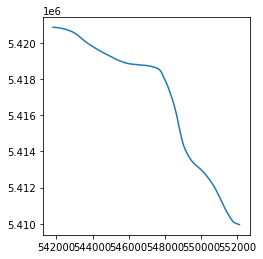

In [21]:
# clipped_centerline_fn = r'..\data\centerlines_dtm\clipped_centerline.shp' #original centerline export
# clipped_centerline_fn = r'..\data\centerlines_dtm\poinchpoint_ncedarville_straight_braidplain.shp' #overflow reach
# clipped_centerline_fn = r'..\data\centerlines_dtm\thalweg_model_domain.shp' #entire domain
clipped_centerline_fn = r'..\data\centerlines_dtm\nooksac_dod_centerline_clipped.shp'
# clipped_centerline_fn = r'..\data\centerlines_dtm\active_channel_belt_center.shp'
clipped_centerline_gdf = gpd.read_file(clipped_centerline_fn, SHAPE_RESTORE_SHX='YES')
clipped_centerline_gdf = clipped_centerline_gdf.to_crs(crs=26910)
clipped_centerline_gdf.geometry.plot()

In [22]:
try:
    linecoords = [list(i.coords) for i in clipped_centerline_gdf.geometry]
    river_centerline = geometry.LineString([i for sublist in linecoords for i in sublist])
except NotImplementedError:
    river_centerline = linemerge(clipped_centerline_gdf.geometry[0])

In [23]:
#create equidistant points along centerline
transect_spacing = 15
along_l_dist, xpts, ypts = line2pts(river_centerline, transect_spacing)

In [24]:
#create transects at equidistant points, specify sampling res
# chan_transects = make_perp_transects_strt_LBank(xpts, ypts, 1000, DEM_res=3)
sampling_res = 4
transect_length = 2000
if param_name in ['overflow_morpho_on_DoD_centerline', 'overflow_morpho_off_DoD_centerline']:
    print('flipping')
    xpts = np.flip(xpts)
    ypts = np.flip(ypts)

chan_transects = make_perp_transects_strt_LBank(xpts, ypts, transect_length, sampling_res)
ntrans = len(chan_transects)

flipping


## Create centerline to extract water surface

### Plot transects

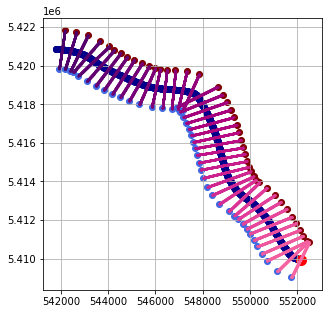

In [26]:
f, ax = mp.subplots(figsize=(5,5))
cm_index = np.linspace(0.5, 1, ntrans) #only going to 0.5 cause colors get too light at end of cmap
ax.plot(xpts,
        ypts,
        color='darkblue',
        marker='o', zorder=0)
ax.scatter(xpts[0],
           ypts[0],
           color='red', s=100, zorder=1)
for i, c_idx in zip(range(ntrans), cm_index):
    if i%25 == 0:
        ax.plot(chan_transects[i][0],
                chan_transects[i][1],
                color=mp.cm.RdPu(c_idx),
                marker='o',
                markersize=1)
        ax.scatter(chan_transects[i][0][0],
                  chan_transects[i][1][0],
                   color='royalblue')
        ax.scatter(chan_transects[i][0][-1],
                   chan_transects[i][1][-1],
                   color='maroon')
frame1 = mp.gca()
ax.grid(True)
# ax.set_xlim([552000, 555000])
# ax.set_ylim([5408000, 5410000])

#### Plot elevation at time 0 with transects

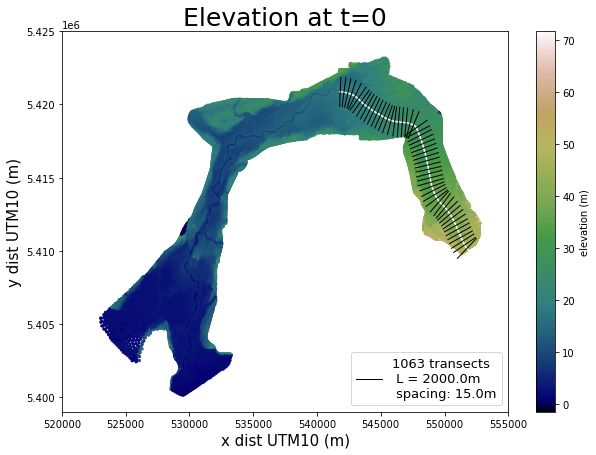

In [28]:
nstart = 30 #id of transects to start at beginning (to figure out grid overlap)
tstep=0
# ymin_filter = 5410900
# xmin_filter = 551000
f, ax = mp.subplots(figsize=(10,7))
ws = ax.scatter(
    mat_contents['G']['face']['FlowElem_x'],
    mat_contents['G']['face']['FlowElem_y'],
    # c=mat_contents['D'][tstep][0]['face']['z_cc'] - (mat_contents['D'][tstep][0]['face']['zwl'] - mat_contents['D'][tstep][0]['face']['dep']), #water surface elev
    c=mat_contents['D'][tstep][0]['face']['z_cc'], #terrain
    cmap='gist_earth',
    s=5
)
ax.plot(xpts,
        ypts,
        color='white',
        zorder=1)
# ax.scatter(xpts[0],
#            ypts[0],
#            color='red', s=100, zorder=2)
#PLOT ALL TRANSECTS
nplot = 20
for i in range(nstart, ntrans, nplot):
    if i==nstart:
        ax.plot(chan_transects[i][0],
                chan_transects[i][1],
                color='k', linewidth=1,
                label='%d transects \n L = %.1fm \n spacing: %.1fm' %(ntrans-nstart, transect_length, transect_spacing))        
    else:
        ax.plot(chan_transects[i][0],
                chan_transects[i][1],
                color='k', linewidth=1)


ax.legend(loc='lower right', fontsize=13)   
# ax.axhline(ymin_filter)
# ax.axvline(xmin_filter)
ax.set_xlim(520000, 555000)
ax.set_ylim(5399000, 5425000)
ax.set_xlabel('x dist UTM10 (m)', fontsize=15)
ax.set_ylabel('y dist UTM10 (m)', fontsize=15)
ax.set_title('Elevation at t=%d'%tstep, fontsize=25)
mp.colorbar(ws, label='elevation (m)')
mp.savefig(r'..\figs\model_output\%s\planform_transects_nplot%d.png'%(param_name, nplot),
           dpi=200,
           bbox_inches='tight')

find xy of starting transect

In [29]:
len(chan_transects)

1093

In [30]:
xpts[nstart+1], ypts[nstart+1] #since no first transect this should be close to xstrt ,y strt

(551742.4001708222, 5410154.144882293)

In [31]:
idx_midpoint = int(len(chan_transects[nstart][0])/2)
xstrt, ystrt = chan_transects[nstart][0][idx_midpoint], chan_transects[nstart][1][idx_midpoint]
xstrt, ystrt

(551742.4001708219, 5410154.144882293)

### Create Storage for transects

In [32]:
transects_df = pd.DataFrame()
X = []
Y = []
d = []
XSEC = []
for i in range(nstart, ntrans):
    npts = len(chan_transects[i][0])
    X.extend(chan_transects[i][0])
    Y.extend(chan_transects[i][1])
    d.extend(chan_transects[i][2])
    XSEC.extend(np.full(npts, i))
    
transects_df['X'] = X
transects_df['Y'] = Y
transects_df['distance_m'] = d
transects_df['XSEC'] = XSEC

transects_gdf = gpd.GeoDataFrame(transects_df, geometry=gpd.points_from_xy(transects_df.X, transects_df.Y), crs='EPSG:26910')

## Sample Delft3D data at nearest x,y points to those in 2006 cross-section data
* https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

This isn't sampling enough points...need to fix

In [328]:
# def ckdnearest(gdA, gdB):

#     nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
#     nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
#     btree = cKDTree(nB)
#     # btree = KDTree(nB)
    
#     dist, idx = btree.query(nA, k=1)
#     # dist, idx = btree.query_ball_point(nA, 10) #do this to search within certain distance
#     gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
#     gdf = pd.concat(
#         [
#             gdA.reset_index(drop=True),
#             gdB_nearest,
#             pd.Series(dist, name='dist')
#         ], 
#         axis=1)

#     return gdf

### Extract values at all transects
* depending on number of transects, this can take awhile

In [33]:
# extract values at all transects
# xs_Z_gdf = ckdnearest(transects_gdf, Z_d3d_gdf)
# xs_zwl_gdf = ckdnearest(transects_gdf, zwl_d3d_gdf)
# xs_depth_gdf = ckdnearest(transects_gdf, depth_d3d_gdf)

#can also do this
xs_Z_gdf = transects_gdf.sjoin_nearest(Z_d3d_gdf, how='left')
xs_zwl_gdf = transects_gdf.sjoin_nearest(zwl_d3d_gdf, how='left')
xs_depth_gdf = transects_gdf.sjoin_nearest(depth_d3d_gdf, how='left')
xs_u_gdf = transects_gdf.sjoin_nearest(u_d3d_gdf, how='left')
xs_v_gdf = transects_gdf.sjoin_nearest(v_d3d_gdf, how='left')

## Save Output

In [34]:
with open(r'..\data\Delft3D\%s\xs_Z.pickle'%param_name, 'wb') as handle:
    pickle.dump(xs_Z_gdf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(r'..\data\Delft3D\%s\xs_zwl.pickle'%param_name, 'wb') as handle:
    pickle.dump(xs_zwl_gdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'..\data\Delft3D\%s\xs_depth.pickle'%param_name, 'wb') as handle:
    pickle.dump(xs_depth_gdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'..\data\Delft3D\%s\xs_u.pickle'%param_name, 'wb') as handle:
    pickle.dump(xs_u_gdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(r'..\data\Delft3D\%s\xs_v.pickle'%param_name, 'wb') as handle:
    pickle.dump(xs_v_gdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

time

In [25]:
model_time = pd.DataFrame()
model_time['timestep'] = range(0, len(model_timestamps))
if filename == 'NOmorpho_d3d_output.p':
    model_time['timestep'] += 72 #rectify with morpho case
model_time['timestamp'] = model_timestamps.values
# model_time.to_csv(r'..\data\Delft3D\%s\model_times%s.csv'%(param_name, param_name))
model_time.to_csv(r'..\data\Delft3D\%s\model_times.csv'%(param_name)) #real way